# Project 1 Notebook

This notebook contains the final code for the MTA project at Metis.

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

### Data Intake

In [2]:
# Import local CSV files and change name of EXITS column

df_dec19 = pd.read_csv('v1december_turnstiles.csv', index_col = 0)
df_dec19 = df_dec19.rename(columns={'EXITS                                                               ':'EXITS'})
df_mar20 = pd.read_csv('v1march_turnstiles.csv', index_col = 0)
df_mar20 = df_mar20.rename(columns={'EXITS                                                               ':'EXITS'})
df_june20 = pd.read_csv('v1june_turnstiles.csv', index_col = 0)
df_june20 = df_june20.rename(columns={'EXITS                                                               ':'EXITS'})

# Create a new column for times in a number format for each data set (XX:XX:XX to XX)
new_time = df_dec19.TIME.map(lambda x: str(x)[:-6])
df_dec19['ABBREV_TIME'] = pd.to_numeric(new_time)

new_time = df_mar20.TIME.map(lambda x: str(x)[:-6])
df_mar20['ABBREV_TIME'] = pd.to_numeric(new_time)

new_time = df_june20.TIME.map(lambda x: str(x)[:-6])
df_june20['ABBREV_TIME'] = pd.to_numeric(new_time)

### Function: Station Separation

In [3]:
# These functions separate stations with the same name, but with different LINENAME or DIVISION

def twoPennStation(dataframe):
    dataframe.loc[(dataframe['STATION'] == '34 ST-PENN STA') & (dataframe['LINENAME'] == '123'), 'STATION'] = '34 ST-PENN EXPRESS'
    dataframe.loc[(dataframe['STATION'] == '34 ST-PENN STA') & (dataframe['LINENAME'] == 'ACE'), 'STATION'] = '34 ST-PENN LOCAL'
    
    # LINENAME 123ACE shares turnstiles with LINENAME ACE
    # Therefore, we add 123ACE into the ACE bin
    dataframe.loc[(dataframe['STATION'] == '34 ST-PENN STA') & (dataframe['LINENAME'] == '123ACE'), 'STATION'] = '34 ST-PENN EXPRESS'
    return dataframe

def three23Station(dataframe):
    # There are three different STATIONS = '23 ST', so we will categorize by DIVISION
    dataframe.loc[(dataframe['STATION'] == '23 ST') & (dataframe['DIVISION'] == 'IRT'), 'STATION'] = '23 ST IRT'
    dataframe.loc[(dataframe['STATION'] == '23 ST') & (dataframe['DIVISION'] == 'IND'), 'STATION'] = '23 ST IND'
    dataframe.loc[(dataframe['STATION'] == '23 ST') & (dataframe['DIVISION'] == 'BMT'), 'STATION'] = '23 ST BMT'
    return dataframe

In [4]:
# Run the codes above for each data set

df_dec19 = twoPennStation(df_dec19)
df_mar20 = twoPennStation(df_mar20)
df_june20 = twoPennStation(df_june20)

df_dec19 = three23Station(df_dec19)
df_mar20 = three23Station(df_mar20)
df_june20 = three23Station(df_june20)

### Function: Differences for 4-Hr Interval Timepoints

In [5]:
def hr4FootTraffic(dataframe):
    """
    This function calculated foot traffic for every 4 hour interval.
    It groups the data by TURNSTILE ("C/A", "UNIT", "SCP","STATION"), DATE, TIME, and TIMESTAMP,
    then aggregates it to show the sum (renamed as TOTAL_FOOTTRAFFIC).
    
    The last line for "station_counts_df" is used to calculate the max foot traffic by
    taking the sum of DEC19, MAR20, and JUNE20.
    """
    dataframe['TIMESTAMP'] = pd.to_datetime(dataframe['DATE'] + ' ' + dataframe['TIME'])
    dataframe['FOOTTRAFFIC'] = dataframe['ENTRIES'] + dataframe['EXITS']
    
    # This aggregates FOOTTRAFFIC by STATION & TIME, it also resets the indez
    hour4_counts_df = dataframe.groupby(["C/A", "UNIT", "SCP","STATION","DATE","TIME","TIMESTAMP",'ABBREV_TIME']).FOOTTRAFFIC.agg(['sum', 'count']).reset_index()

    # This creates a new column of DIFF_FOOTRAFFIC by taking the difference in 'sum'
    hour4_counts_df['DIFF_FOOTTRAFFIC'] = hour4_counts_df['sum'].diff()

    # For practical purposes, we will rename 'sum' to TOTAL_FOOTTRAFFIC
    hour4_counts_df = hour4_counts_df.rename(columns={'sum':'TOTAL_FOOTTRAFFIC'})

    return hour4_counts_df

In [6]:
# Apply the function to each and data set. Include 'month_n_of_rows' to calculate rows.
# The number of rows will be used later to see what will be changed.

df_dec19_4hrfoottraffic = hr4FootTraffic(df_dec19)
dec_n_of_rows = df_dec19_4hrfoottraffic.shape[0]

df_mar20_4hrfoottraffic = hr4FootTraffic(df_mar20)
mar_n_of_rows = df_mar20_4hrfoottraffic.shape[0]

df_june20_4hrfoottraffic = hr4FootTraffic(df_june20)
june_n_of_rows = df_june20_4hrfoottraffic.shape[0]

### Function: Remove Outliers and Replace with Median

In [7]:
def cleanTraffic(dataframe):
    """
    This function cleans the data. We replace turnstile resets (negative values or VERY big vallues)
    with NaN, and then replace them with the median value as phantom values.
    """
    #All values below 0 will now also be Not a Number
    dataframe[dataframe['DIFF_FOOTTRAFFIC'] < 0] = np.nan
    
    #Turnstile averages will saved as DIFF_FOOTTRAFFIC aggregate
    grouped = dataframe.groupby(['C/A', 'UNIT', 'SCP','STATION'])['DIFF_FOOTTRAFFIC'].median()
    
    #Then merged to the original dataframe, creating an extra DIFF_FOOTTRAFFIC
    #one will be named DIFF_FOOTTRAFFIC_x , the other DIFF_FOOTTRAFFIC_y
    dataframe = pd.merge(dataframe, grouped,  how='left',
                         left_on=['C/A', 'UNIT', 'SCP','STATION'],
                         right_on = ['C/A', 'UNIT', 'SCP','STATION'])
    
    #A column with original name will be created, filling in nans with means
    dataframe['DIFF_FOOTTRAFFIC'] = dataframe.DIFF_FOOTTRAFFIC_x.fillna(dataframe.DIFF_FOOTTRAFFIC_y)
    
    #Deleting the original, now unconventionally spelled with NaNs in it 
    del dataframe['DIFF_FOOTTRAFFIC_x']
    
    #Keeping a column for turnstile average as needed
    dataframe = dataframe.rename(columns = {'DIFF_FOOTTRAFFIC_y':'MEDIANTRAFFIC'})
    
    #Removing large positive outliers in the dataset 90th percentile
    dataframe = dataframe[dataframe.DIFF_FOOTTRAFFIC < dataframe.DIFF_FOOTTRAFFIC.quantile(.90)]

    return dataframe

In [8]:
# Add a DAYOFWEEK for Sat, Sun, Mon, etc. This will be used for plotting later

df_dec19_4hrfoottraffic['DAYOFWEEK'] = pd.to_datetime(df_dec19_4hrfoottraffic['DATE']).dt.dayofweek
df_mar20_4hrfoottraffic['DAYOFWEEK'] = pd.to_datetime(df_mar20_4hrfoottraffic['DATE']).dt.dayofweek
df_june20_4hrfoottraffic['DAYOFWEEK'] = pd.to_datetime(df_june20_4hrfoottraffic['DATE']).dt.dayofweek

# Check what the column looks like
df_dec19_4hrfoottraffic.head(5)

,C/A,UNIT,SCP,STATION,DATE,TIME,TIMESTAMP,ABBREV_TIME,TOTAL_FOOTTRAFFIC,count,DIFF_FOOTTRAFFIC,DAYOFWEEK
0,A002,R051,02-00-00,59 ST,11/30/2019,03:00:00,2019-11-30 03:00:00,3,9761420,1,NaN,5
1,A002,R051,02-00-00,59 ST,11/30/2019,07:00:00,2019-11-30 07:00:00,7,9761447,1,27.0,5
2,A002,R051,02-00-00,59 ST,11/30/2019,11:00:00,2019-11-30 11:00:00,11,9761593,1,146.0,5
3,A002,R051,02-00-00,59 ST,11/30/2019,15:00:00,2019-11-30 15:00:00,15,9761859,1,266.0,5
4,A002,R051,02-00-00,59 ST,11/30/2019,19:00:00,2019-11-30 19:00:00,19,9762258,1,399.0,5


In [9]:
# Check how much data is cleaned

df_dec19_4hrfoottraffic = cleanTraffic(df_dec19_4hrfoottraffic)
print('Dec rows ', dec_n_of_rows, ' now: ', df_dec19_4hrfoottraffic.shape[0], '\n')

df_mar20_4hrfoottraffic = cleanTraffic(df_mar20_4hrfoottraffic)
print('Mar rows ', mar_n_of_rows, ' now: ', df_mar20_4hrfoottraffic.shape[0], '\n')

df_june20_4hrfoottraffic = cleanTraffic(df_june20_4hrfoottraffic)
print('June rows ', june_n_of_rows, ' now: ', df_mar20_4hrfoottraffic.shape[0], '\n')

Dec rows  618712  now:  549388 

Mar rows  616471  now:  547565 

June rows  620072  now:  547565 



In [10]:
# Quick check of what the dataframe looks like

df_dec19_4hrfoottraffic.head(5)

,C/A,UNIT,SCP,STATION,DATE,TIME,TIMESTAMP,ABBREV_TIME,TOTAL_FOOTTRAFFIC,count,DAYOFWEEK,MEDIANTRAFFIC,DIFF_FOOTTRAFFIC
0,A002,R051,02-00-00,59 ST,11/30/2019,03:00:00,2019-11-30 03:00:00,3.0,9761420.0,1.0,5.0,294.0,294.0
1,A002,R051,02-00-00,59 ST,11/30/2019,07:00:00,2019-11-30 07:00:00,7.0,9761447.0,1.0,5.0,294.0,27.0
2,A002,R051,02-00-00,59 ST,11/30/2019,11:00:00,2019-11-30 11:00:00,11.0,9761593.0,1.0,5.0,294.0,146.0
3,A002,R051,02-00-00,59 ST,11/30/2019,15:00:00,2019-11-30 15:00:00,15.0,9761859.0,1.0,5.0,294.0,266.0
4,A002,R051,02-00-00,59 ST,11/30/2019,19:00:00,2019-11-30 19:00:00,19.0,9762258.0,1.0,5.0,294.0,399.0


### Function: Create a TURNSTILE Column

TURNSTILE is defined by unique groupings of "C/A", "UNIT", "SCP", "STATION"

In [11]:
def turnstileColumn(dataframe):
    '''
    Takes an MTA dataframe & creates a new column
    Where there's an index number for each Turn Stile in frame.
    '''
    eachTS = dataframe.groupby(["C/A", "UNIT", "SCP", "STATION"])[['DIFF_FOOTTRAFFIC']].sum()
    howMany = eachTS.shape[0]
    eachTS['TURNSTILE'] = range(1,(howMany + 1))
    del eachTS['DIFF_FOOTTRAFFIC']
    dataframe = pd.merge(dataframe, eachTS,  how='left',
                         left_on=['C/A','UNIT','SCP', 'STATION'],
                         right_on = ['C/A','UNIT','SCP', 'STATION'])    
    return dataframe

In [12]:
# Apply function to all 4_hr traffic data.

df_dec19_4hrfoottraffic = turnstileColumn(df_dec19_4hrfoottraffic)
df_mar20_4hrfoottraffic = turnstileColumn(df_mar20_4hrfoottraffic)
df_june20_4hrfoottraffic = turnstileColumn(df_june20_4hrfoottraffic)


# Groups the data by STATION and takes the SUM of all DIFF_FOOTTRAFFICS from said STATION
df_dec19_maxfoottraffic = df_dec19_4hrfoottraffic.groupby(["STATION"], as_index=False)["DIFF_FOOTTRAFFIC"].sum()
df_mar20_maxfoottraffic = df_mar20_4hrfoottraffic.groupby(["STATION"], as_index=False)["DIFF_FOOTTRAFFIC"].sum()
df_june20_maxfoottraffic = df_june20_4hrfoottraffic.groupby(["STATION"], as_index=False)["DIFF_FOOTTRAFFIC"].sum()

### Create Combined Dataset of Total Foot Traffic

In [13]:
# Checking the top 20 most trafficked stations; the majority in top 10 match

total_foottraffic = df_dec19_maxfoottraffic.set_index('STATION').\
    join(df_mar20_maxfoottraffic.set_index('STATION'), lsuffix = '_DEC').\
    join(df_june20_maxfoottraffic.set_index('STATION'), lsuffix = '_MAR', rsuffix = '_JUNE')

total_foottraffic['DIFF_FOOTTRAFFIC_TOTAL'] = total_foottraffic['DIFF_FOOTTRAFFIC_DEC'] +\
    total_foottraffic['DIFF_FOOTTRAFFIC_JUNE'] + total_foottraffic['DIFF_FOOTTRAFFIC_MAR']

total_foottraffic = total_foottraffic.sort_values('DIFF_FOOTTRAFFIC_TOTAL', ascending=False).reset_index()

total_foottraffic_top10 = total_foottraffic.sort_values('DIFF_FOOTTRAFFIC_TOTAL', ascending=False).reset_index().head(10)

total_foottraffic_top10

,index,STATION,DIFF_FOOTTRAFFIC_DEC,DIFF_FOOTTRAFFIC_MAR,DIFF_FOOTTRAFFIC_JUNE,DIFF_FOOTTRAFFIC_TOTAL
0,0,FULTON ST,1983448.0,654067.0,355076.0,2992591.0
1,1,86 ST,1706099.0,600540.0,297415.0,2604054.0
2,2,34 ST-PENN LOCAL,1642792.0,480101.0,280787.0,2403680.0
3,3,GRD CNTRL-42 ST,1580469.0,600121.0,200067.0,2380657.0
4,4,59 ST,1553536.0,465495.0,222464.0,2241495.0
5,5,CANAL ST,1516187.0,418639.0,214003.0,2148829.0
6,6,34 ST-HERALD SQ,1356545.0,508357.0,256336.0,2121238.0
7,7,125 ST,1374726.0,517337.0,219002.0,2111065.0
8,8,42 ST-PORT AUTH,1447790.0,425339.0,136271.0,2009400.0
9,9,14 ST,1371040.0,395325.0,192717.0,1959082.0


### Plots!

Text(0, 0.5, 'Average Daily Foot Traffic (Thousands)')

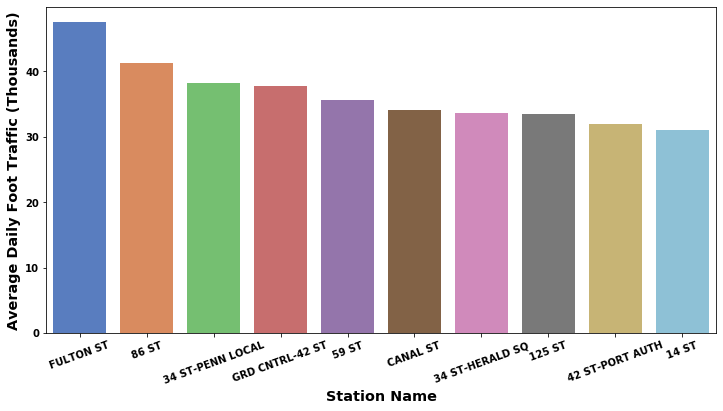

In [18]:
# Top 10 Stations Plot

plt.figure(figsize=[12, 6])
font = {'family': 'sans-serif', 'weight': 'bold'}
plt.rc('font', **font)

# Divide by 1e6 for millions, divide by [7 days x 3 weeks x 3 months]
ax1 = sns.barplot(x = 'STATION', y = total_foottraffic_top10['DIFF_FOOTTRAFFIC_TOTAL']/1000/7/3/3,
                  data = total_foottraffic_top10,
                  palette = "muted",)
plt.xticks(rotation=20)
ax1.set_xlabel('Station Name', fontdict=font, fontsize='x-large')
ax1.set_ylabel('Average Daily Foot Traffic (Thousands)', fontdict=font, fontsize='x-large')
# lt.title('Top 10 Stations', fontdict=font, fontsize='xx-large');

### PLOTTING CODE IS BELOW. UNCOMMENT TO USE ###

# plt.savefig('top10_stations.png', dpi = 300)

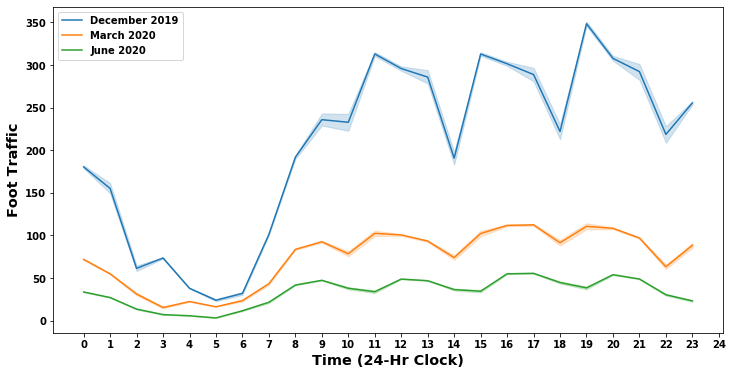

In [15]:
# Plot of Amount of Riders per Month

plt.figure(figsize=[12, 6])
font = {'family': 'sans-serif', 'weight': 'bold'}
plt.rc('font', **font)

# December 2019 data
ax1 = sns.lineplot(x = 'ABBREV_TIME', y = df_dec19_4hrfoottraffic['DIFF_FOOTTRAFFIC'],
                  data = df_dec19_4hrfoottraffic,
                  palette = "muted",)

# March 2020 data
sns.lineplot(x = 'ABBREV_TIME', y = df_mar20_4hrfoottraffic['DIFF_FOOTTRAFFIC'],
                     data = df_mar20_4hrfoottraffic,
                     palette = "muted", ax = ax1)

# June 2020 data
sns.lineplot(x = 'ABBREV_TIME', y = df_june20_4hrfoottraffic['DIFF_FOOTTRAFFIC'],
                     data = df_june20_4hrfoottraffic,
                     palette = "muted", ax = ax1)

ax1.set_xlabel('Time (24-Hr Clock)', fontdict=font, fontsize='x-large')
ax1.set_ylabel('Foot Traffic', fontdict=font, fontsize='x-large')

plt.legend(['December 2019', 'March 2020', 'June 2020'])
plt.xticks(rotation=0)
plt.xticks(np.arange(0, 25, 1.0));
#plt.title('Amount of Riders/Month', fontdict=font, fontsize='xx-large');

### PLOTTING CODE IS BELOW. UNCOMMENT TO USE ###

# plt.savefig('traffic_24hr_interval.png', dpi = 300)

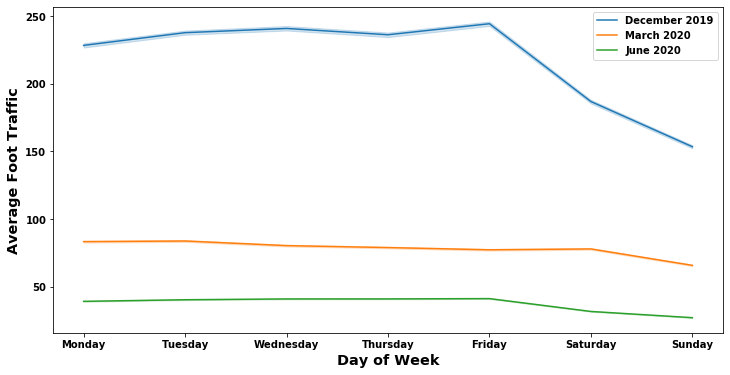

In [19]:
# Ridership per day of week

# Use Series.dt.day_name(self, *args, **kwargs)

plt.figure(figsize=[12, 6])
font = {'family': 'sans-serif', 'weight': 'bold'}
plt.rc('font', **font)

# December 2019 data, divide by 3/4 b/c we use 3/4 of a month (3 weeks data)
ax1 = sns.lineplot(x = 'DAYOFWEEK', y = df_dec19_4hrfoottraffic['DIFF_FOOTTRAFFIC'],
                  data = df_dec19_4hrfoottraffic,
                  palette = "muted",)

# March 2020 data
sns.lineplot(x = 'DAYOFWEEK', y = df_mar20_4hrfoottraffic['DIFF_FOOTTRAFFIC'],
                     data = df_mar20_4hrfoottraffic,
                     palette = "muted", ax = ax1)

# June 2020 data
sns.lineplot(x = 'DAYOFWEEK', y = df_june20_4hrfoottraffic['DIFF_FOOTTRAFFIC'],
                     data = df_june20_4hrfoottraffic,
                     palette = "muted", ax = ax1)

ax1.set_xlabel('Day of Week', fontdict=font, fontsize='x-large')
ax1.set_ylabel('Average Foot Traffic', fontdict=font, fontsize='x-large')
ax1.set_xticklabels(['','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.legend(['December 2019', 'March 2020', 'June 2020']);

### PLOTTING CODE IS BELOW. UNCOMMENT TO USE ###

# plt.savefig('dayofweek_traffic.png', dpi = 300)